<a href="https://colab.research.google.com/github/dong-gi-jang/binfo/blob/main/Free%202/Free2_Fig5A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free 2
## LIN28A is a suppressor of ER-associated translation in embryonic stem cells
[위 논문](https://doi.org/10.1016/j.cell.2012.10.019)의 Fig.5A (GO enrichment analysis) 재현하기

In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## installation

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

!conda install -y subread

## import dataset

Subread featurecounts이용한 transcript별 read count 계산.

multi-mapping도 고려해야 하는가?
 - ignore all : transcript level에서는 이건 안됨? complete exons would be ignored.[[1]](https://www.sciencedirect.com/science/article/pii/S2001037020303032)
   - 그런데 기존 week1 read-counts.txt 파일은 gene level에서, 이렇게?
 - count once per alignment (-M)
 - equally split (-M --fraction)
   - 그러나 truly expressed gene을 underestimate할 가능성

In [2]:
%cd /content/drive/MyDrive/binfo1-datapack1/

# run subread
# to equally split,
# !featureCounts -a gencode.gtf -o read-counts_es.txt -M --fraction *.bam 

# to ignore,
# !featureCounts -a gencode.gtf -o read-counts.txt *.bam 

/content/drive/MyDrive/binfo1-datapack1


In [4]:
# 그런데 우선은 ignore 결과인 기존 week1 read-counts.txt 파일 가져와서 진행.
import pandas as pd
import numpy as np
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

## read-counts matrix processing

In [5]:
# 각 컬럼의 sum (total assigned read count)으로 normalize?
# 전체 bam파일 수준에서의 align reads 수로 normalize?

# 일단은 featurecounts 결과에서의 각 column의 total sum으로 normalize 시도
cnts['log2_clip_enrichment'] = np.log2(   (cnts['CLIP-35L33G.bam']/cnts['CLIP-35L33G.bam'].sum() ) / (cnts['RNA-control.bam']/cnts['RNA-control.bam'].sum() ) )
cnts['log2_rden_change'] = np.log2( (   (cnts['RPF-siLin28a.bam']/cnts['RPF-siLin28a.bam'].sum()) / (cnts['RNA-siLin28a.bam']/cnts['RNA-siLin28a.bam'].sum() ) / ( (cnts['RPF-siLuc.bam']/cnts['RPF-siLin28a.bam'].sum() )/ (cnts['RNA-siLuc.bam']/cnts['RNA-siLuc.bam'].sum()))))

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# Geneid(index) 마다 있는 점 뒤쪽 제거하여 우선은 gene level에서 보기
import copy

cnts_rmdot = copy.deepcopy(cnts)
cnts_rmdot.index = cnts_rmdot.index.map(lambda p : p.split('.')[0])

In [9]:
# cutoff 정해, low abundant 제거하기
# 논문 따라하려면 어떻게?
# exclude transcripts with low ribosome occupancy(<80 raw reads in siLuc) 즉, RPF-siLuc >80
rna_cutoff = 30
ribo_cutoff = 80

ribobool = cnts_rmdot['RPF-siLuc.bam'] > ribo_cutoff
rnabool = cnts_rmdot['RNA-siLuc.bam'] > rna_cutoff
lin28abool = cnts_rmdot['RNA-siLin28a.bam'] > rna_cutoff

# clipbool = cnts_rmdot['RNA-control.bam'] > rna_cutoff

cnts_cutoff = cnts_rmdot[ribobool & rnabool & lin28abool]

In [19]:
# log2 처리 시 nan값, -inf값 포함 여부 확인
print('nan # : ',len(cnts_cutoff[cnts_cutoff['log2_clip_enrichment'].isnull() | cnts_cutoff['log2_rden_change'].isnull()]))
print('-inf # : ', len(cnts_cutoff[(cnts_cutoff['log2_clip_enrichment']==-np.inf) | (cnts_cutoff['log2_rden_change']==-np.inf) ]))

nan # :  0
-inf # :  4


In [20]:
# -inf값 4개 있어서, 제거된 df 이용
cnts_noinf = cnts_cutoff[cnts_cutoff['log2_clip_enrichment']!=-np.inf]

In [21]:
# matrix에 포함된 gene 목록 추출
raw_genelist= cnts_noinf.index.tolist()
# 중복된 gene 여부 확인
print(len(raw_genelist),len(set(raw_genelist)))

8070 8070


## Identifier mapping

In [ ]:
# EnsEMBL Gene ID를 gene symbol, uniprot accession으로 mapping 위해,
!pip install gseapy

In [24]:
import gseapy as gp
bm = gp.parser.Biomart()

Creating directory /root/.cache/bioservices 
Welcome to Bioservices
It looks like you do not have a configuration file.
We are creating one with default values in /root/.config/bioservices/bioservices.cfg .
Done


In [209]:
a = bm.get_attributes('mmusculus_gene_ensembl')

In [211]:
a

,Attribute,Description
0,ensembl_gene_id,Gene stable ID
1,ensembl_gene_id_version,Gene stable ID version
2,ensembl_transcript_id,Transcript stable ID
3,ensembl_transcript_id_version,Transcript stable ID version
4,ensembl_peptide_id,Protein stable ID
...,...,...
2875,cdna,cDNA sequences
2876,coding,Coding sequence
2877,peptide,Peptide
2878,upstream_flank,upstream_flank


In [222]:
a[a['Attribute'].str.contains('go_id')]

,Attribute,Description
41,go_id,GO term accession


In [226]:
a[a['Description'].str.contains('GO')]

,Attribute,Description
41,go_id,GO term accession
42,name_1006,GO term name
43,definition_1006,GO term definition
44,go_linkage_type,GO term evidence code
45,namespace_1003,GO domain
46,goslim_goa_accession,GOSlim GOA Accession(s)
47,goslim_goa_description,GOSlim GOA Description


In [25]:
# biomart에서도 go_id 가져올 수 있음.
result = bm.query(dataset='mmusculus_gene_ensembl',attributes=['ensembl_gene_id','external_gene_name','go_id'],filters={'ensembl_gene_id':raw_genelist})

In [232]:
# GO domain, GO tern name도 가져올 수 있었음. 이것 이용하여 GOCC 처리하자.
result3 =  bm.query(dataset='mmusculus_gene_ensembl',attributes=['ensembl_gene_id','external_gene_name','namespace_1003','name_1006'],filters={'ensembl_gene_id':raw_genelist})

In [233]:
result3

,ensembl_gene_id,external_gene_name,namespace_1003,name_1006
0,ENSMUSG00000024304,Cdh2,molecular_function,protein binding
1,ENSMUSG00000024304,Cdh2,cellular_component,synapse
2,ENSMUSG00000024304,Cdh2,cellular_component,synapse
3,ENSMUSG00000024304,Cdh2,molecular_function,protein-containing complex binding
4,ENSMUSG00000024304,Cdh2,biological_process,homeostasis of number of cells
...,...,...,...,...
488641,ENSMUSG00000067847,Romo1,biological_process,cellular response to reactive oxygen species
488642,ENSMUSG00000067847,Romo1,biological_process,cytolysis by host of symbiont cells
488643,ENSMUSG00000067847,Romo1,biological_process,protein insertion into mitochondrial inner mem...
488644,ENSMUSG00000067847,Romo1,biological_process,replicative senescence


In [26]:
# 생각보다 행 내 값 전체가 중복되는 행들 많음. 제거.
result_nodup = result.drop_duplicates(['ensembl_gene_id','external_gene_name','go_id'])
result_nodup

,ensembl_gene_id,external_gene_name,go_id
0,ENSMUSG00000024304,Cdh2,GO:0005515
1,ENSMUSG00000024304,Cdh2,GO:0045202
3,ENSMUSG00000024304,Cdh2,GO:0044877
4,ENSMUSG00000024304,Cdh2,GO:0048872
5,ENSMUSG00000024304,Cdh2,GO:0048854
...,...,...,...
488551,ENSMUSG00000067847,Romo1,GO:0034614
488552,ENSMUSG00000067847,Romo1,GO:2000379
488555,ENSMUSG00000067847,Romo1,GO:0051838
488559,ENSMUSG00000067847,Romo1,GO:0045039


In [27]:
# 개수 한 번 확인
totalgenelist = set(result_nodup['ensembl_gene_id'].tolist())
len(totalgenelist)

8070

## Define categorial terms

- 그런데 GO CC는 상위 term만 이용했었으니까, 위 방법에서 추려진 GO term 전체 이용하지 말고, 각 customized categorial term만 이용 및,
CC 하위 term들은 다 빼고 보기?
- GO term 분류 위해서는 GO term이 CC BP MF 중 무엇인지 알려주는 데이터셋 찾아서 가져와야 할 듯.
- 차후 말풍선에도 넣기 위해서는 GO-id, CCBPMF, term 설명해주는 데이터셋 찾기.

In [28]:
# gene_id는 달라도 gene_name은 같은 경우도 고려 필요
# -> 일단 gene_id 이용.
# figure엔 mitochondrion 있지만, method엔 mitochondrion 안 써있음. 이유?

# 논문 method 참고, categorial term 설정. 전부 GO:CC 관련 term들. 
ccdict = {'mitochondrial_membrane':'GO:0031966',  
          'nucleus':'GO:0005634', 
          'integral_component_of_membrane':'GO:0016021',
          'cytoplasm':'GO:0005737',
          'extracellular_region':'GO:0005576',
          'cell_surface':'GO:0009986',
          'Golgi_apparatus':'GO:0005794',
          'endoplasmic_reticulum':'GO:0005783',
          'mitochondrion':'GO:0005739'
          }
for i,j in ccdict.items():
  globals()['gocc_{}'.format(i)] = result_nodup[result_nodup['go_id']==j]
  globals()['gocc_{}_unique'.format(i)] = set(globals()['gocc_{}'.format(i)]['ensembl_gene_id'].tolist())

In [29]:
# 논문에서는 GO:0031966(mitochondrial membrane)에 대한 각각의 차집합을 이용함. 이유는?
# 우선 얼마나 겹치는 게 많은지부터 보자.
cclist = list(ccdict)

print('mitochondrial_membrane : ', len(gocc_mitochondrial_membrane_unique))

for i in cclist:
  if i!='mitochondrial_membrane':
    print()
    print(i,':', len(globals()['gocc_{}_unique'.format(i)]))
    print('intersection :',len(globals()['gocc_{}_unique'.format(i)] & gocc_mitochondrial_membrane_unique))

mitochondrial_membrane :  116

nucleus : 3461
intersection : 26

integral_component_of_membrane : 1680
intersection : 76

cytoplasm : 3605
intersection : 29

extracellular_region : 286
intersection : 4

cell_surface : 225
intersection : 3

Golgi_apparatus : 712
intersection : 3

endoplasmic_reticulum : 867
intersection : 21

mitochondrion : 1193
intersection : 107


In [30]:
# nucleus - mito mem
# integral mem - mito mem
# cytoplasm - mito mem
# ER associated : integral mem + extracell + surface + golgi + er - mito mem
# non ER : total - ER associated - mito mem

gocc_final_unique_nucleus = gocc_nucleus_unique - gocc_mitochondrial_membrane_unique
gocc_final_unique_integral_component_of_membrane = gocc_integral_component_of_membrane_unique - gocc_mitochondrial_membrane_unique
gocc_final_unique_cytoplasm = gocc_cytoplasm_unique - gocc_mitochondrial_membrane_unique
gocc_final_unique_ER =  (gocc_integral_component_of_membrane_unique | gocc_extracellular_region_unique | gocc_cell_surface_unique | gocc_Golgi_apparatus_unique | gocc_endoplasmic_reticulum_unique) - gocc_mitochondrial_membrane_unique
gocc_final_unique_nonER = (totalgenelist - gocc_final_unique_ER) - gocc_mitochondrial_membrane_unique

In [ ]:
# 각 GO term별, match된 input dataset 내 gene 수 
# 각 GO term을 구성하는 gene 정보를 가져오지 않았기 때문에, overlap은 계산할 수 없음. 단지 count만.
# GO term 자체의 hierarchy 높을수록 구성 gene 수 많을 텐데.

count={}
lists = result_nodup['go_id'].tolist()
for i in lists:
    try: count[i] += 1
    except: count[i]=1
print(count)

In [36]:
# 내림차순 정렬
sorted_count = sorted(count.items(), key = lambda item: item[1],reverse=True)

- ensembl, logC, logR : cnts_noinf
- ensembl, GO ID : result_nodup
- GO ID sorted : sorted_count

In [84]:
!pip install tqdm
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Statistical test

In [94]:
# GO term count 높은 것부터 순서대로,
# 각 GO term의 member와 member 제외 전체 gene들의 log2 C, R 가져오기
from scipy import stats

stat_result = pd.DataFrame(columns=['GO-term','count','CLIP_mean','Rden_mean','Clip_p-value','Rden_p-value'])
for i,j in tqdm(sorted_count[1:]): #index 0은 nan이라 무시함.
  temp_genelist = result_nodup[result_nodup['go_id']==i]['ensembl_gene_id'].tolist()
  gomember = cnts_noinf[cnts_noinf.index.isin(temp_genelist)]
  others =  cnts_noinf[~cnts_noinf.index.isin(temp_genelist)]

  logC_avg = np.mean(gomember['log2_clip_enrichment'])
  logR_avg = np.mean(gomember['log2_rden_change'])


  Clip_pvalue = list(stats.mannwhitneyu(gomember['log2_clip_enrichment'],others['log2_clip_enrichment']))[1]
  Rden_pvalue = list(stats.mannwhitneyu(gomember['log2_rden_change'],others['log2_rden_change']))[1]

  row = [i,j,logC_avg, logR_avg, Clip_pvalue, Rden_pvalue ]
  stat_result = stat_result.append(pd.Series(row, index=stat_result.columns), ignore_index=True)

100%|██████████| 14593/14593 [06:15<00:00, 38.88it/s]


In [122]:
stat_result_rdenp_sorted = stat_result.sort_values('Rden_p-value')

In [123]:
# p-value 같은 값 있어도, 다음 rank는 1만 증가시키는 방법(dense) 이용?
# https://stats.stackexchange.com/questions/18872/how-to-deal-with-identical-p-values-with-the-benjamini-hochberg-method-for-corre
stat_result_rdenp_sorted['Rden_p-value_rank'] = stat_result_rdenp_sorted['Rden_p-value'].rank(method='dense')

In [119]:
# 대안) R package 이용하는 방법
# https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ossiriand&logNo=220860705917
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

p_adjust = stats.p_adjust(FloatVector(stat_result_rdenp_sorted['Rden_p-value']), method = 'BH')

In [127]:
stat_result_rdenp_sorted['Rden_FDR']=list(p_adjust)

In [129]:
# 오래걸리니까 일단 저장
stat_result_rdenp_sorted.to_csv('./total_result_fdr.csv')

In [130]:
# FDR 0.05 cutoff
stat_result_fdr = stat_result_rdenp_sorted[stat_result_rdenp_sorted['Rden_FDR']<0.05]

In [133]:
stat_result_fdr.head()

,GO-term,count,CLIP_mean,Rden_mean,Clip_p-value,Rden_p-value,Rden_p-value_rank,Rden_FDR
6,GO:0016021,1680,0.116223,0.040942,1.033685e-146,0.000000e+00,1.0,0.000000e+00
3,GO:0016020,2762,-0.212355,-0.230549,4.822372e-83,1.897114e-240,2.0,1.384229e-236
1,GO:0005634,3461,-0.724884,-0.718815,1.080217e-16,2.078980e-133,3.0,1.011285e-129
13,GO:0005783,867,0.052653,-0.088539,6.683996e-56,3.370508e-121,4.0,1.229646e-117
27,GO:0005789,511,0.198027,0.005975,1.521795e-45,1.523852e-100,5.0,4.447515e-97


## enrichr (일단 사용 안함)


In [38]:
# enrichr
# GO database 가져오기
mouselib = gp.get_library_name(organism='Mouse')
mousegolib = [s for s in mouselib if "GO" in s] 
mousegolib2021 = [s for s in mousegolib if "2021" in s]
mousegolib2021

['GO_Biological_Process_2021',
 'GO_Cellular_Component_2021',
 'GO_Molecular_Function_2021']

In [60]:
# enrichr
# gene_sets 리스트로 넣어주면 왜 한 종류만 나올까. 지난 번 수업 시간에 KEGG 했을때도 다시보니 한종류 geneset만 결과 나왔었더라.
# 따로따로 testing해서 테이블 이어 붙혀도 상관 없나.
enrcc= gp.enrichr(gene_list = upreg_genenames, gene_sets=mousegolib2021[1],organism='Mouse',description='',outdir='test/enrichr_go2021',cutoff=0.05)
enrmf= gp.enrichr(gene_list = upreg_genenames, gene_sets=mousegolib2021[2],organism='Mouse',description='',outdir='test/enrichr_go2021',cutoff=0.05)
enrbp= gp.enrichr(gene_list = upreg_genenames, gene_sets=mousegolib2021[0],organism='Mouse',description='',outdir='test/enrichr_go2021',cutoff=0.05)

In [68]:
# enrichr
enrconcat = pd.concat([enrbp.res2d,enrcc.res2d,enrmf.res2d])
enrconcat

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,mRNA processing (GO:0006397),267/300,2.928254e-70,1.707172e-66,0,0,12.328116,1.973812e+03,TCERG1;RAMAC;CCNH;EIF4A3;GPATCH1;HNRNPU;HNRNPR...
1,GO_Biological_Process_2021,"mRNA splicing, via spliceosome (GO:0000398)",245/274,1.773668e-65,5.170242e-62,0,0,12.840775,1.914495e+03,EIF4A3;GPATCH1;HNRNPU;HNRNPR;WDR83;CCAR1;PNN;S...
2,GO_Biological_Process_2021,"RNA splicing, via transesterification reaction...",227/251,6.157058e-63,9.679117e-60,0,0,14.349037,2.055432e+03,EIF4A3;GPATCH1;HNRNPU;HNRNPR;WDR83;CCAR1;PNN;S...
3,GO_Biological_Process_2021,rRNA processing (GO:0006364),170/173,6.640904e-63,9.679117e-60,0,0,85.498334,1.224076e+04,RPL4;POP5;RPL5;RPL30;RPL3;RPL32;RPL31;POP4;RPL...
4,GO_Biological_Process_2021,ribosome biogenesis (GO:0042254),184/192,6.307342e-62,7.354361e-59,0,0,34.749271,4.896817e+03,LTV1;RPL4;POP5;RPL5;RPL30;RPL3;RPL32;RPL31;POP...
...,...,...,...,...,...,...,...,...,...,...
1163,GO_Molecular_Function_2021,chemokine receptor binding (GO:0042379),1/50,9.999964e-01,9.999968e-01,0,0,0.030031,1.084362e-07,ITCH
1164,GO_Molecular_Function_2021,CCR chemokine receptor binding (GO:0048020),1/42,9.999966e-01,9.999968e-01,0,0,0.035915,1.218540e-07,CNIH4
1165,GO_Molecular_Function_2021,steroid hydroxylase activity (GO:0008395),1/36,9.999968e-01,9.999968e-01,0,0,0.042093,1.352583e-07,CYP2S1
1166,GO_Molecular_Function_2021,neuropeptide receptor activity (GO:0008188),1/30,9.999968e-01,9.999968e-01,0,0,0.050827,1.612278e-07,SSTR2


## visualize
- 그래프 위 각 balloon에 쓰인 C, R 숫자는 
pvalue값이라서 범위가 옆의 colorbar 수치를 넘어가는 것으로 보임.
 color바 및 bubble color 자체는 adjusted, FDR 값임.
- bubble size는 overlap ratio 아닌 count로.
- GO term 내 transcript들의 FDR이 0.05 미만인 것으로 cutoff 정한 후,
- 하위 subset terms were omitted.



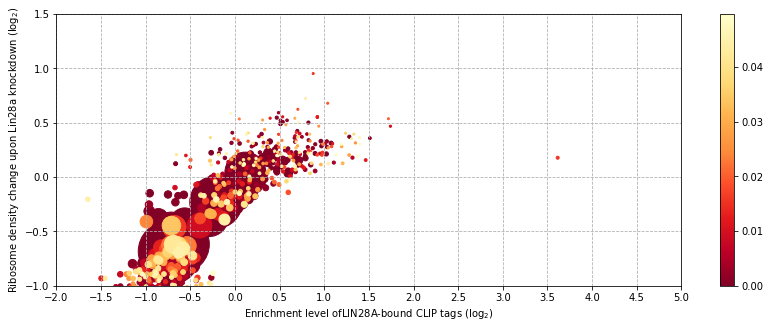

In [177]:
# visulaize

# 우선 최대한 파이썬의 scatter(bubble plot) 등으로 표현해보기
# 각 bubble 주변에 label(말풍선 및 화살표) 적절히 놓을 수 있는 방법? 
# plt fig ax, subplot 사용?
from matplotlib import pyplot as plt
plt.figure(figsize=(14,5))
plt.xlabel('Enrichment level ofLIN28A-bound CLIP tags ($\log_2$)')
plt.ylabel('Ribosome density change upon Lin28a knockdown ($\log_2$)')
plt.xlim(-2,5)
plt.ylim(-1,1.5)
plt.xticks(np.arange(-2, 5.01, step=0.5))
plt.yticks(np.arange(-1, 1.51, step=0.5))
plt.grid(True, linestyle='--')
plt.scatter(stat_result_fdr['CLIP_mean'],stat_result_fdr['Rden_mean'],s=stat_result_fdr['count'].tolist(),c=stat_result_fdr['Rden_FDR'].tolist(),cmap='YlOrRd_r')
plt.colorbar()
b.ax.set_ylabel('Term-specific enrichment confidence (false discovery rate)', rotation=90, labelpad = -60)
b.ax.set_yticklabels([10**-20,10**-18,10**-16,10**-14,10**-12,10**-10,10**-8,10**-6,10**-4,10**-2,10**-0])
None